<a href="https://colab.research.google.com/github/madziejm/1e100-ibu/blob/master/1e100ibu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preliminary

#### Dependencies

In [5]:
import torch
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'dev = {dev}')

dev = cpu


In [6]:
try: # mount user's Google Drive if on Colab to save training artifacts
    from google.colab import drive
    drive.mount('/drive')
    ROOT_DIR = '/content/'
    MODEL_ROOT_DIR = '/drive/MyDrive/Colab Notebooks/1e100ibu/saves/'
except ImportError:
    ROOT_DIR = './'
    MODEL_ROOT_DIR = './saves/'

Mounted at /drive


In [7]:
!pip install --quiet icecream
# !pip install --quiet -Iv torch==1.10.1
# !pip install --quiet -Iv torchtext==0.11.1

In [8]:
from icecream import ic
import os

## Dataset representation

In [1]:
!pip install 'spacy<3.3.0,>=3.2.0' --quiet
!python -m spacy download en_core_web_sm --quiet
!python -m spacy download pl_core_news_md --quiet

     |████████████████████████████████| 6.0 MB 7.0 MB/s 
     |████████████████████████████████| 181 kB 54.8 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
     |████████████████████████████████| 451 kB 71.8 MB/s 
     |████████████████████████████████| 628 kB 65.7 MB/s 
     |████████████████████████████████| 10.1 MB 26.4 MB/s 
     |████████████████████████████████| 13.9 MB 4.6 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     |████████████████████████████████| 87.9 MB 28 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('pl_core_news_md')


In [2]:
!pip show spacy | egrep Version
# we want SpaCy 3
!pip show torch | egrep Version
!pip show torchtext | egrep Version

Version: 3.2.1
Version: 1.10.0+cu111
Version: 0.11.0


#### dataset representation

In [3]:
from collections import Counter
from torchtext._torchtext import (Vocab as VocabPybind) # make use of some hidden interface
from torchtext.vocab import Vocab, build_vocab_from_iterator
from tqdm.notebook import trange, tqdm
import gc # garbage collector interface
import io
import re
import spacy # nlp toolkit
import torch
import pickle


class BaseReviews(torch.utils.data.Dataset):
    def __init__(self, aspects, aspect_max, aspect_ratings, texts, unkn_tok, _len, anchor_words):
        self.aspects = aspects
        self.aspect_count = len(aspects)
        self.aspect_max = aspect_max
        self._aspect_ratings = aspect_ratings
        self._texts = texts
        self.unkn_tok = unkn_tok
        self._len = _len
        self.anchor_words = anchor_words
        self.vocab = None

    def dump(self, dest_path, filename):
        contents = {
            'aspects'        : self.aspects,
            'aspect_max'     : self.aspect_max,
            '_aspect_ratings': self._aspect_ratings,
            '_texts'         : self._texts,
            'unkn_tok'       : self.unkn_tok,
            '_len'           : self._len,
            'anchor_words'   : self.anchor_words,
            'vocab'          : self.vocab,
        }
        with open(f'{dest_path}/{filename}', 'wb') as f:
            pickle.dump(contents, f)
    
    def load(self, dest_path, filename):
        with open(f'{dest_path}/{filename}', 'rb') as f:
            contents = pickle.load(f)
            self.aspects         = contents['aspects']
            self.aspect_max      = contents['aspect_max']
            self._aspect_ratings = contents['_aspect_ratings']
            self._texts          = contents['_texts']
            self.unkn_tok        = contents['unkn_tok']
            self._len            = contents['_len']
            self.anchor_words    = contents['anchor_words']
            self.vocab           = contents['vocab']

    def __getitem__(self, i):
        # # 1 # python
        # sentences = tuple(sent for sent in self._texts[i])
        # ratings = tuple(self._aspect_ratings[a][i] for a in range(self.aspect_count))
        # 2 # tensor
        sentences = tuple(torch.LongTensor(sent) for sent in self._texts[i])
        # changed LongTensor to IntTensor
        ratings = torch.IntTensor(tuple(int(self._aspect_ratings[a][i]) for a in range(self.aspect_count)))
        # # 3 # dev
        # sentences = tuple(torch.tensor(sent) for sent in self._texts[i])
        # ratings = torch.tensor(tuple(self._aspect_ratings[a][i] for a in range(self.aspect_count)))
        return (sentences, ratings)

    def __len__(self):
        return self._len

In [9]:
class RateBeerReviews(BaseReviews):
    """
    beer/name: John Harvards Simcoe IPA
    beer/beerId: 63836
    beer/brewerId: 8481
    beer/ABV: 5.4
    beer/style: India Pale Ale &#40;IPA&#41;
    review/appearance: 4/5
    review/aroma: 6/10
    review/palate: 3/5
    review/taste: 6/10
    review/overall: 13/20
    review/time: 1157587200
    review/profileName: hopdog
    review/text: On tap at the Springfield, PA location. Poured a deep and cloudy orange (almost a copper) color with a small sized off white head. Aromas or oranges and all around citric. Tastes of oranges, light caramel and a very light grapefruit finish. I too would not believe the 80+ IBUs - I found this one to have a very light bitterness with a medium sweetness to it. Light lacing left on the glass.
    """
    def __init__(self):
        aspects = ['appearance', 'aroma', 'palate', 'taste', 'overall']
        super().__init__(
            aspects        = aspects,
            aspect_max     = [5, 10, 5, 10, 20],
            aspect_ratings = [ [] for _ in aspects ],
            texts          = [],
            unkn_tok       = '<unk>', # unknown/out of vocabulary token
            _len            = 0,
            anchor_words = {
                'appearance' : ('appearance', 'color'),
                'aroma'      : ('aroma'),
                'palate'     : ('palate', 'mouthfeel'),
                'taste'      : ('taste'),
                'overall'    : ('overall'),
            },
        )
        self.pipe = None

    def build(self, filepath=f'{ROOT_DIR}/SNAP-Ratebeer.txt', max_reviews=float('inf'), min_word_freq=None, max_word_count=None):
        with io.open(filepath, encoding='utf-8') as f:
            for line in tqdm(f, total=(40938282 if max_reviews == float('inf') else max_reviews * 14), desc='Reading data'):
                if line == '\n': # separator
                    self._len += 1
                    if max_reviews <= self._len:
                        break
                elif line.startswith('review/appearance: '):
                    line = line[len('review/appearance: '):]
                    self._aspect_ratings[0].append(int(line.split('/')[0])) # lhs of split by '/' is rating, rhs is max possible rating
                elif line.startswith('review/aroma: '):
                    line = line[len('review/aroma: '):]
                    self._aspect_ratings[1].append(int(line.split('/')[0])) # lhs of split by '/' is rating, rhs is max possible rating
                elif line.startswith('review/palate: '):
                    line = line[len('review/palate: '):]
                    self._aspect_ratings[2].append(int(line.split('/')[0])) # lhs of split by '/' is rating, rhs is max possible rating
                elif line.startswith('review/taste: '):
                    line = line[len('review/taste: '):]
                    self._aspect_ratings[3].append(int(line.split('/')[0])) # lhs of split by '/' is rating, rhs is max possible rating
                elif line.startswith('review/overall: '):
                    line = line[len('review/overall: '):]
                    self._aspect_ratings[4].append(int(line.split('/')[0])) # lhs of split by '/' is rating, rhs is max possible rating
                elif line.startswith('review/text: '):
                    line = line[len('review/text: '):]
                    if line.startswith('UPDATED:'):
                        line = line[len("UPDATED: APR 29, 2008"):] # drop prefix
                    line = re.sub('~', ' ', line.strip()) # remove whitespace incl. trailing newline and tildes that can be found in data for some reason
                    if line:
                        self._texts.append(line)
                    else: # some reviews do not have associated text; unwind (remove) their ratings for each aspect
                        for aspect_ratings in self._aspect_ratings:
                            aspect_ratings.pop()
                        self._len -= 1
        self._post_process(min_word_freq, max_word_count) # 20K words should be okay
    
    def _fetch_nlp_pipeline(self):
        if not self.pipe:
            nlp = spacy.util.get_lang_class('en')()
            nlp.add_pipe("sentencizer", config={"punct_chars": ['.', '?', '!']})
            nlp.Defaults.stop_words |= { '-', '+'}
            nlp.Defaults.stop_words -= {'mostly', 'whole', 'indeed', 'quite', 'ever', 'nothing', 'perhaps', 'not', 'no', 'only', 'well', 'really', 'except'}
            self.pipe = lambda reviews: nlp.pipe(reviews)
    
    def _free_nlp_pipeline(self):
        self.nlp = None

    def tokenize_reviews(self, reviews_texts: str):
        return [tuple(list(tok.lower_ for tok in sent if not tok.is_stop and not tok.is_punct and not tok.is_space and len(tok) > 2) for sent in doc.sents if 0 != len(sent)) for doc in self.pipe(reviews_texts)]
    
    def id_map_reviews(self, texts):
        return [tuple(self.vocab.lookup_indices(sent) for sent in text) for text in texts]
    
    def _post_process(self, min_word_freq=None, max_word_count=None):
        assert (min_word_freq is not None) ^ bool(max_word_count is not None), "provide one of min_word_freq and max_word_count"
        self._fetch_nlp_pipeline()
        print("Spacy pipe (tokenization&sentence split)..")
        gc.collect() # force garbage collection
        self._texts = self.tokenize_reviews(self._texts)
        for i, text in enumerate(self._texts):
            assert 0 != len(text) # make sure no empty reviews again (new could be introduced by removing stop words unfortunately)
        print("Building vocab (word-id mapping)..")
        gc.collect() # force garbage collection
        sent_gen = (sent for text in self._texts for sent in text)
        if min_word_freq:
            self.vocab = build_vocab_from_iterator(sent_gen, specials=[self.unkn_tok], min_word_freq=5)
        else:
            words = Counter()
            for tokens in sent_gen:
                words.update(tokens)
            words = [word for word, freq in words.most_common(max_word_count)] # list sorted by frequency yikees
            self.vocab = Vocab(VocabPybind(words, None))
        self.vocab.insert_token(self.unkn_tok, 0)
        self.vocab.set_default_index(self.vocab[self.unkn_tok]) # set index for out-of-vocabulary words
        print("Mapping words to ids..")
        gc.collect() # force garbage collection
        self._texts = self.id_map_reviews(self._texts)
        gc.collect() # force garbage collection

If you want to read dataset from dataset file, set USE_RATEBEER_PICKLE to true in the cell below and RECREATE_PICKLE to True. If you left them untouched, it'lle be read from serialized `RateBeerReviews` class object instead of parsing text file.

In [10]:
%env USE_RATEBEER_PICKLE=true

env: USE_RATEBEER_PICKLE=true


In [11]:
%%bash

if [ "$USE_RATEBEER_PICKLE" = true ]
then # download pickle
    if [ ! -f './ratebeer-20K-vocab.pickle' ]
    then
        gdown --id '1VBDjyR4jpzAgzcDUGNQFguOfLC3rtOV_' # https://drive.google.com/file/d/1VBDjyR4jpzAgzcDUGNQFguOfLC3rtOV_/view?usp=sharing  # 20K words dataset
        # gdown --id '1ebDMDlOxtFh8B5i8lajR7q3kq-0hM02j' # https://drive.google.com/file/d/1ebDMDlOxtFh8B5i8lajR7q3kq-0hM02j/view?usp=sharing # min frequency 5 words dataset
    fi
else # download original dataset
    if [ ! -f './SNAP-Ratebeer.txt' ]
    then
        gdown --id '12tEEYQcHZtg5aWyfIiWWVIDAJNT-5d_T' # https://drive.google.com/file/d/12tEEYQcHZtg5aWyfIiWWVIDAJNT-5d_T/view?usp=sharing
        echo "Dataset head (trailing newline makes entry end): "
        export $RATEBEER_FILE='./SNAP-Ratebeer.txt'
        head -n 16 $RATEBEER_FILE
        iconv -f ISO-8859-1 -t UTF-8 $RATEBEER_FILE -o {RATEBEER_FILE}.new && mv {RATEBEER_FILE}.new $RATEBEER_FILE
    fi
fi

Downloading...
From: https://drive.google.com/uc?id=1VBDjyR4jpzAgzcDUGNQFguOfLC3rtOV_
To: /content/ratebeer-20K-vocab.pickle
100%|██████████| 316M/316M [00:08<00:00, 35.9MB/s]


In [12]:
rb = RateBeerReviews()

if os.environ.get('USE_RATEBEER_PICKLE') == 'true':
    rb.load('./', 'ratebeer-20K-vocab.pickle')
else: # build pickle
    rb.build('./SNAP-Ratebeer.txt', max_word_count=20000)
    print('Dumping..')
    rb.dump('./', 'ratebeer-20K-vocab.pickle')

In [ ]:
from collections import Counter
from torchtext._torchtext import (Vocab as VocabPybind) # make use of some hidden interface
from torchtext.vocab import Vocab, build_vocab_from_iterator
from tqdm.notebook import trange, tqdm
import gc # garbage collector interface
import io
import re
import spacy # nlp toolkit
import torch
import json

class OcenPiwoReviews(BaseReviews):
    def __init__(self):
        aspects = ['ogólny', 'smak', 'zapach', 'wygląd',]
        super().__init__(
            aspects        = aspects,
            aspect_max     = [10, 10, 10, 10],
            aspect_ratings = [ [] for _ in aspects ],
            texts          = [],
            unkn_tok       = '<unk>', # unknown/out of vocabulary token
            _len            = 0,
            anchor_words = {
                'ogólny'     : ('ogólnie'),
                'smak'       : ('smak'),
                'zapach'     : ('zapach'),
                'wygląd'     : ('wygląd', 'wygląda')
            },
        )
        self.pipe = None

    def build(self, filepath=f'{ROOT_DIR}/ocen-piwo-utf8.json', min_word_freq=None, max_word_count=None):
        with io.open(filepath, encoding='utf-8') as f:
            json_dict = json.loads(f.read())

            for i, reviews in enumerate(json_dict.values()):
                for sentences, ratings in reviews:
                    self._len += 1

                    for aspect in range(self.aspect_count):
                        self._aspect_ratings[aspect].append(int(ratings[aspect]))

                    self._texts.append(sentences)

                # TODO: check
                if self._len >= 10:
                    break
        self._post_process(min_word_freq, max_word_count)

    def _fetch_nlp_pipeline(self):
        if not self.pipe:
            nlp = spacy.load('pl_core_news_md')
            nlp.add_pipe("sentencizer", config={"punct_chars": ['.', '?', '!']})
            nlp.Defaults.stop_words |= { '-', '+'}
            self.pipe = lambda reviews: nlp.pipe(reviews)
    
    def _free_nlp_pipeline(self):
        self.nlp = None

    def tokenize_reviews(self, reviews_texts: str):
        return [tuple(list(tok.lemma_ for tok in sent if not tok.is_stop and not tok.is_punct and not tok.is_space and len(tok) > 2) \
            for sent in doc.sents if 0 != len(sent)) for doc in self.pipe(reviews_texts)]
    
    def id_map_reviews(self, texts):
        return [tuple(self.vocab.lookup_indices(sent) for sent in text) for text in texts]
    
    def _post_process(self, min_word_freq=None, max_word_count=None):
        assert (min_word_freq is not None) ^ bool(max_word_count is not None), "provide one of min_word_freq and max_word_count"
        self._fetch_nlp_pipeline()
        print("Spacy pipe (tokenization&sentence split)..")
        gc.collect() # force garbage collection
        self._texts = self.tokenize_reviews(self._texts)
        for i, text in enumerate(self._texts):
            assert 0 != len(text) # make sure no empty reviews again (new could be introduced by removing stop words unfortunately)
        print("Building vocab (word-id mapping)..")
        gc.collect() # force garbage collection
        sent_gen = (sent for text in self._texts for sent in text)
        if min_word_freq:
            self.vocab = build_vocab_from_iterator(sent_gen, specials=[self.unkn_tok], min_word_freq=5)
        else:
            words = Counter()
            for tokens in sent_gen:
                words.update(tokens)
            words = [word for word, freq in words.most_common(max_word_count)] # list sorted by frequency yikees
            self.vocab = Vocab(VocabPybind(words, None))
        self.vocab.insert_token(self.unkn_tok, 0)
        self.vocab.set_default_index(self.vocab[self.unkn_tok]) # set index for out-of-vocabulary words
        print("Mapping words to ids..")
        gc.collect() # force garbage collection
        self._texts = [tuple(self.vocab.lookup_indices(sent) for sent in text) for text in self._texts]
        gc.collect() # force garbage collection

In [ ]:
%env USE_OCENPIWO_PICKLE=true

env: USE_OCENPIWO_PICKLE=true


In [ ]:
%%bash

if [ "$USE_OCENPIWO_PICKLE" = true ]
then # download pickle
    if [ ! -f './ocenpiwo-20K-vocab.pickle' ]
    then
        gdown --id '1zUXnY0UqvevNnePThTfquF6hUxxPOls9' # https://drive.google.com/file/d/1zUXnY0UqvevNnePThTfquF6hUxxPOls9/view  # 20K words dataset
    fi
else # download original dataset
    if [ ! -f './ocen-piwo-utf8.json' ]
    then
        gdown --id '1RM_Sk8QeOQnjnje0gwxQfJIOIK0KLLWV' # https://drive.google.com/file/d/1RM_Sk8QeOQnjnje0gwxQfJIOIK0KLLWV
    fi
fi

In [ ]:
op = OcenPiwoReviews()

if os.environ.get('USE_OCENPIWO_PICKLE') == 'true':
    op.load('./', 'ocenpiwo-20K-vocab.pickle')
else: # build pickle
    op.build('./ocen-piwo-utf8.json', max_word_count=20000)
    print('Dumping..')
    op.dump('./', 'ocenpiwo-20K-vocab.pickle')

If you want to read dataset from dataset file, set FETCH_RATEBEER to true in the cell below and RECREATE_PICKLE to True. If you left them untouched, it'lle be read from serialized `RateBeerReviews` class object instead of parsing text file.

### Training (implementation of $(1)$)

In [14]:
from torch.utils.data import random_split, DataLoader
import datetime
from scipy.optimize import linear_sum_assignment
from more_itertools import grouper

# for wordcloudsdest_path=dest_path
import numpy as np
import os
import re
from PIL import Image
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import functools
from operator import iadd
from typing import List

class AspectModel():
    def __init__(self, dataset):
        self.ds = dataset
        self.init_weights()

    def init_weights(self):
        word_count = len(self.ds.vocab.get_itos())
        self.theta = torch.rand((word_count, self.ds.aspect_count), device=dev)
        # scale to [-0.1, 0.0], as we enforce this weight to 1.0 for some words later on
        self.theta = self.theta * -0.1
        # scale to [0.0, 0.9], as we enforce this weight to 1.0 for some words later on
        # self.theta = self.theta * 0.9
        # enforce 1 initialization on aspect name (page 4)
        # aspect_ids = self.ds.vocab.lookup_indices(self.ds.aspects)
        for aspect_idx, aspect in enumerate(self.ds.aspects):
            words = self.ds.anchor_words[aspect]

            if isinstance(words, str):
                words = [words]
            else:
                words = list(words)

            words_ids = self.ds.vocab.lookup_indices(words)
            for word_id in words_ids:
                self.theta[word_id, aspect_idx] = 1.0
        self.theta.requires_grad_()

        # introduce separate phi for each aspect
        # self.phis = [torch.rand((word_count, self.ds.aspect_max[i])).to(dev) for i in range(self.ds.aspect_count)]
        self.phis = [torch.zeros((word_count, self.ds.aspect_max[i]), device=dev, dtype=self.theta.dtype) for i in range(self.ds.aspect_count)]
        # # normalize that sum across all words is 1 for a given aspect (eq. 7) # do not normalize as for now
        # self.phis = [phi / phi.sum(dim=0) for phi in self.phis]
        for phi in self.phis: phi.requires_grad_()
    
    def word_clouds(self, dest_path=MODEL_ROOT_DIR, filename='words.png', show=True):
        # words = self.ds.vocab.get_itos()
        words = list(str(unicodedata.normalize('NFD', x).encode('ascii', 'ignore'))[2:-1] for x in self.ds.vocab.get_itos())
        fig = plt.figure(figsize=(max(self.ds.aspect_max) + 1, len(self.ds.aspects)))
        plt.subplots_adjust(wspace=0.2)
        # plt.subplots_adjust(wspace=0.01, hspace=0.000000001)
        # plt.tight_layout()
        i = 0

        for aspect in range(self.ds.aspect_count):
            aspect_name = self.ds.aspects[aspect]
            atheta = self.theta[:, aspect].tolist()
            
            zipped = list(zip(words, atheta))

            wc = WordCloud(background_color="white", color_func=lambda *args, **kwargs: 'black', width=1000, height=1000)
            wc.generate_from_frequencies(dict(zipped))

            fig.add_subplot(self.ds.aspect_count, max(self.ds.aspect_max) + 1, i * (max(self.ds.aspect_max) + 1) + 1)
            plt.imshow(wc)
            plt.title(f'{aspect_name} Theta', fontsize=2)
            plt.axis("off")

            for rating in range(self.ds.aspect_max[aspect]):
                aphi = self.phis[aspect][:, rating].tolist()

                zipped = list(zip(words, aphi))
                sorted_zip = sorted(zipped, reverse=True, key=lambda x: x[1])[:200]

                if any(a == 0 for _, a in sorted_zip):
                    print(f'Omitting {aspect_name} Phi {str(rating + 1)}')
                    continue

                wc = WordCloud(background_color="white", color_func=lambda *args, **kwargs: 'black', width=1000, height=1000)
                wc.generate_from_frequencies(dict(zipped))
                fig.add_subplot(self.ds.aspect_count, max(self.ds.aspect_max) + 1, i * (max(self.ds.aspect_max) + 1) + rating + 2)

                plt.imshow(wc)
                plt.title(f'{aspect_name} Phi {str(rating + 1)}', fontsize=2)
                plt.axis("off")

            i += 1
        plt.savefig(f'{dest_path}/{filename}', dpi=600)
        plt.show(block=show)
    
    def rev_words_thetas(self, rev_sens_ids):
        """
        TODO filename sentence_aspects_likelihood_theta
        """
        return [self.theta[sen_ids] for sen_ids in rev_sens_ids]

    def rev_words_phis(self, rev_sens_ids):
        """
        TODO filename sentence_aspects_likelihood_phi
        """
        return [[self.phis[aspect_idx][sen_ids, :] for aspect_idx in range(self.ds.aspect_count)] for sen_ids in rev_sens_ids]
    
    def dump_weights(self, dest_path=MODEL_ROOT_DIR, filename=''):
        weights = {'phis': self.phis, 'theta': self.theta}
        torch.save(weights,  f'{dest_path}/{filename}')

    def load_weights(self, src_path):
        weights = torch.load(src_path, map_location=torch.device(dev))
        self.theta = weights['theta']
        self.phis  = weights['phis']
    
    def _linear_assignement(self, costs):
        # for nll we want to minimize
        return linear_sum_assignment(costs, maximize=False)
    
    def plot_nll_history(self, dir, filename):
        plt.figure().set_facecolor('white') # no alpha please
        plt.xlabel('epoch')
        plt.ylabel('NLL')
        plt.xlim(left=0.0, right=self.train_epoch_history[-1])
        plt.ylim(bottom=min(0.0, min(self.train_nll_history)), top=max(max(self.train_nll_history), max(self.test_nll_history)))
        plt.plot(self.train_epoch_history, self.train_nll_history, '-o')
        plt.plot(self.test_epoch_history, self.test_nll_history, '-o')
        plt.legend(['train batch NLL', 'test mean batch NLL'], loc='upper right')
        plt.title('Train and test dataset NLL')
        plt.savefig(os.path.join(dir, filename))
        plt.show()

    @staticmethod
    def experiments(dataset, root_dir=MODEL_ROOT_DIR):
        for _ in range(1):
            directory = str(datetime.datetime.now()) + '-adam'
            path = os.path.join(root_dir, directory)
            os.mkdir(path)

            model = AspectModel(dataset)
            model.train(dest_path=path, optim='adam')

        for _ in range(2):
            directory = str(datetime.datetime.now())
            path = os.path.join(root_dir, directory)
            os.mkdir(path)
            
            model = AspectModel(dataset)
            model.train(dest_path=path)

    def test_nll(self, debug=False):
        nlls = []
        with torch.no_grad():
            test_loader = DataLoader(self.test_ds, batch_size=100, collate_fn=lambda x: x) # do not use default collate function as it requires fixed-length input and raises this exception otherwise https://github.com/pytorch/pytorch/issues/42654
            for i, batch in enumerate(tqdm(test_loader, desc='test validation')):
                batch_nlls = []
                for (rev_sents_ids, review_aspects_scores) in batch:
                    rev_thetas = self.rev_words_thetas(rev_sents_ids)
                    rev_phis   = self.rev_words_phis(rev_sents_ids)
                    aspect_sents_scores = torch.stack(
                        [
                        rev_thetas[j].sum(dim=0) + torch.stack(tuple(rev_phis[j][a][:, review_aspects_scores[a] - 1].sum() for a in range(self.ds.aspect_count))) # 1 x aspect count
                        for j in range(len(rev_sents_ids))
                        ],
                    ) # sent count x aspect count
                    softmax = torch.nn.functional.log_softmax(aspect_sents_scores, dim=1)

                    sents_aspect_preds_max = torch.argmin(softmax, dim=1)
                    row_ind, col_ind = self._linear_assignement(costs=softmax.detach().cpu().numpy())
                    sents_aspect_preds_linear = sents_aspect_preds_max

                    sents_aspect_preds_linear[row_ind] = torch.from_numpy(col_ind).to(dev)
                    
                    batch_nlls.append(softmax.take_along_dim(sents_aspect_preds_linear[:, None], dim=1).sum().cpu().item())
                nlls.append(functools.reduce(lambda a, b: a + b, batch_nlls))
        nll_sum = functools.reduce(lambda a, b: a + b, nlls)
        if debug: ic(nll_sum)
        if debug: ic(torch.exp(-torch.tensor(nll_sum)))
        mean_batch_nll = nll_sum / len(nlls)
        return mean_batch_nll

    def show_inference(self, reviews: List[str]):
        self.ds._fetch_nlp_pipeline()
        tokenized_reviews = self.ds.tokenize_reviews(reviews)
        
        ided_reviews = self.ds.id_map_reviews(tokenized_reviews)

        revs_sents_aspect_preds = []
        revs_sents_rating_preds = []
        # aspect inference
        for rev_sents_ids in ided_reviews:
            rev_thetas = self.rev_words_thetas(rev_sents_ids)
            rev_phis   = self.rev_words_phis(rev_sents_ids)
            # why don't we use torch.nn.LogSoftmax after all?
            aspect_sents_scores = torch.stack(
                [
                rev_thetas[j].sum(dim=0) + torch.stack(tuple(rev_phis[j][a][:].sum() / self.ds.aspect_max[a] for a in range(self.ds.aspect_count))) # 1 x aspect count
                    for j in range(len(rev_sents_ids)) # sentence
                ],
            ) # sent count x aspect count
            softmax = torch.nn.functional.log_softmax(aspect_sents_scores, dim=1)

            sents_aspect_preds_max = torch.argmin(softmax, dim=1) # min of nll === max likelihood
            row_ind, col_ind = self._linear_assignement(costs=softmax.detach().cpu().numpy())
            sents_aspect_preds_linear = sents_aspect_preds_max

            sents_aspect_preds_linear[row_ind] = torch.from_numpy(col_ind).to(dev)
            revs_sents_aspect_preds.append(sents_aspect_preds_linear)
            
             
            sents_rating_preds = [
                torch.stack(tuple(rev_phis[j][a][:, :].sum(dim=0) 
                    for j in range(len(rev_sents_ids)) if sents_aspect_preds_linear[j] == a)) # number_of_sentences x aspect_ratings
                    .sum(dim=0)
                    .argmax()
                    .item() + 1 # lowest score is 1
                    for a in range(self.ds.aspect_count)
            ]

            # s = [torch.stack(tuple(rev_phis[j][a][:, :]
            #         for j in range(len(rev_sents_ids)) if sents_aspect_preds_linear[j] == a)) # number_of_sentences x aspect_ratings
            #         .sum(dim=0)
            #         for a in range(self.ds.aspect_count)]
            # ic(s)

            revs_sents_rating_preds.append(sents_rating_preds)


        for i in range(len(reviews)):
            print(f'Review {i}: ')
            print(f'Tokenized review text (stop words removed):')
            print(*(tokenized_reviews[i]))
            print(f'Review text mapped to word ID-s:', *(ided_reviews[i]))
            print(f'Predicted sentences aspects: ', *[self.ds.aspects[target_idx] for target_idx in (revs_sents_aspect_preds[i])])
            print(f'Predicted aspects ratings: ', *[f'{aspect}: {(revs_sents_rating_preds[i][aspect_idx])}' for aspect_idx, aspect in enumerate(self.ds.aspects)])
            print()

    def train(self, dest_path=MODEL_ROOT_DIR, epoch_count=1, optim='sgd'):
        train_size = int(0.8 * len(self.ds))
        test_size = len(self.ds) - train_size

        params = (
            self.theta,
            *self.phis
        )
        # lr = 0.0005 # for ratebeer; remove
        batch_size = 100
        lr = sum(self.ds.aspect_max) * 1e-7 / batch_size

        weight_decay = 0.0001
        momentum = 0.1
        if optim == 'sgd':
            self._optim = torch.optim.SGD(
                params=params,
                lr=lr,
                weight_decay=weight_decay,
                momentum=momentum
            )
        elif optim == 'adam': # do not use Adam, weights go to NaN with it for some reason
            self._optim = torch.optim.Adam(
                params=params,
                lr=lr,
                weight_decay=weight_decay,
                betas=(momentum, 0.999) # the first is params momentum, second RMSProp momentum (for now fix to 0.999 which is default Pytorch value)
            )
        else:
            assert False
        self._sched = torch.optim.lr_scheduler.StepLR(self._optim, step_size=1, gamma=0.95)


        self.train_ds, self.test_ds = random_split(self.ds, [train_size, test_size])
        train_loader = DataLoader(self.train_ds, batch_size=100, shuffle=True, collate_fn=lambda x: x) # do not use default collate function as it requires fixed-length input and raises this exception otherwise https://github.com/pytorch/pytorch/issues/42654

        self.train_epoch_history = []
        self.test_epoch_history = []
        self.train_nll_history = []
        self.test_nll_history = []
        try:
            for epoch in range(epoch_count):
                batch_count = len(train_loader)
                for i, batch in enumerate(tqdm(train_loader, desc=f'train epoch {epoch}/{epoch_count}')):
                    batch_nlls = []
                    for (rev_sents_ids, review_aspects_scores) in batch:
                        # for sent_ids in rev_sents_ids: sent_ids.to(dev)
                        rev_thetas = self.rev_words_thetas(rev_sents_ids)
                        rev_phis   = self.rev_words_phis(rev_sents_ids)

                        # why don't we use torch.nn.LogSoftmax after all?

                        aspect_sents_scores = torch.stack(
                            [
                            rev_thetas[j].sum(dim=0) + torch.stack(tuple(rev_phis[j][a][:, review_aspects_scores[a] - 1].sum() for a in range(self.ds.aspect_count))) # 1 x aspect count
                            for j in range(len(rev_sents_ids))
                            ],
                        ) # sent count x aspect count
                        softmax = torch.nn.functional.log_softmax(aspect_sents_scores, dim=1)

                        sents_aspect_preds_max = torch.argmin(softmax, dim=1)
                        row_ind, col_ind = self._linear_assignement(costs=softmax.detach().cpu().numpy())
                        sents_aspect_preds_linear = sents_aspect_preds_max

                        # (most likely) aspect assignments (5)
                        sents_aspect_preds_linear[row_ind] = torch.from_numpy(col_ind).to(dev)
                        
                        # sentence likelihood (6)
                        batch_nlls.append(softmax.take_along_dim(sents_aspect_preds_linear[:, None], dim=1).sum())

                    batch_nll = torch.stack(batch_nlls).sum()
                    self._optim.zero_grad(set_to_none=True)
                    if 0 == i % 100:
                        self.train_nll_history.append(batch_nll.cpu().detach().item())
                        self.train_epoch_history.append(epoch + i / batch_count)
                    if 0 == i % 5000:
                        if i != 0:
                            self.dump_weights(dest_path=dest_path, filename=(f'-epoch-{epoch}-{epoch_count}-{int(i)}'))
                            self.word_clouds(dest_path=dest_path, filename=(f'cloud-epoch-{epoch}-{epoch_count}-{int(i)}.png'))
                            # ic(self.rev_words_thetas([self.ds.vocab.lookup_indices(['taste', 'aroma', 'palete', 'antrunk'])]))
                        self.test_nll_history.append(self.test_nll())
                        self.test_epoch_history.append(epoch + i / batch_count)
                    batch_nll.backward()

                    self._optim.step()
                self._sched.step()

            self.dump_weights(dest_path=dest_path, filename=(f'weights-end'))
            self.word_clouds(dest_path=dest_path, filename=(f'cloud-end.png'))
            self.plot_nll_history(dest_path, (f'plot-end.png'))

        except KeyboardInterrupt:
            print('Interrupted.')

            self.dump_weights(dest_path=dest_path, filename=(f'weights-interrupt'))
            self.word_clouds(dest_path=dest_path, filename=(f'cloud-interrupt.png'))
            self.plot_nll_history(dest_path, (f'plot-interrupt.png'))

        except Exception as e:
            ic(len(batch_nlls))
            ic(rev_sents_ids)

            self.dump_weights(dest_path=dest_path, filename=(f'weights-exception'))
            self.word_clouds(dest_path=dest_path, filename=(f'cloud-exception.png'))
            self.plot_nll_history(dest_path, (f'plot-exception.png'))

            ic(batch_nll)
            ic((len(rev_sents_ids),))
            raise e

In [15]:
# %%capture output
# %%script python --no-raise-error
model = AspectModel(op)
# model.train()
AspectModel.experiments(op, root_dir='./saves/')

NameError: ignored

In [ ]:
output.show()

In [ ]:
# %store output > output_log
import pickle
with open('output', 'wb') as f:
    pickle.dump(output, f)

In [ ]:
# danger
# model.ds.vocab.lookup_indices([0])

In [16]:
model_rb = AspectModel(rb) # single run
# model.train()
model_rb.load_weights('/drive/MyDrive/2022-01-23 23:17:15.922108/weights-end')

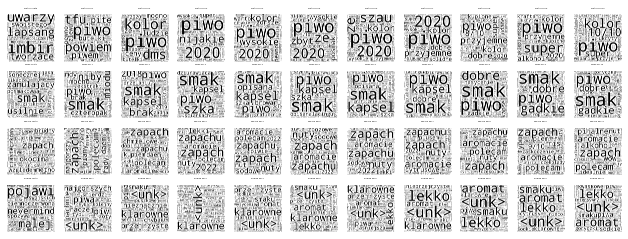

In [ ]:
model.word_clouds()

In [ ]:
model.show_inference([
    'Good-looking bootle. Aroma is pretty astonishig. Sour and sweet palate profile. I like the taste very much. Overall I can recommend it to everyone.',
    'Tastes best from bottle. Not so heap as one could think. Nice hoppy smell. I had not supposed it will be sour though. Beautiful smooth head.',
])

OSError: ignored

In [27]:
from torch.cuda import device
from traitlets.traitlets import Float
from itertools import combinations, product, permutations
from functools import reduce
from torch.utils.data import random_split, DataLoader
import torch
import matplotlib.pyplot as plt
import numpy

class RatingModel():
    def __init__(self, dataset, aspect_model):
        self.ds = dataset
        self.model = aspect_model
        self.init_weights(aspect_model)

    def init_weights(self, aspect_model):
        word_count = len(self.ds.vocab.get_itos())

        if not aspect_model:
            self.gammas = [torch.zeros((word_count, self.ds.aspect_max[i]), requires_grad=False, device=dev) for i in range(self.ds.aspect_count)]
        else:
            self.gammas = [phi.clone().detach().requires_grad_(False).to(device=dev) for phi in aspect_model.phis]

        self.alphas = {comb : torch.zeros((self.ds.aspect_max[comb[0]], self.ds.aspect_max[comb[1]]), 
                                         requires_grad=True, device=dev, dtype=self.gammas[0].dtype) for comb in combinations(range(self.ds.aspect_count), 2)}
        
        # we keep references to alphas for reversed keys
        # optimization stonks
        for comb in list(self.alphas.keys()):
            self.alphas[(comb[1], comb[0])] = self.alphas[comb]

        self.rating_tuples = torch.stack([torch.tensor(prod, dtype=torch.int) for prod in product(*[range(aspect_max) for aspect_max in self.ds.aspect_max])])

    def rev_words_gammas(self, rev_sens_ids):
        return [[self.gammas[aspect_idx][sen_ids, :] for aspect_idx in range(self.ds.aspect_count)] for sen_ids in rev_sens_ids]

    def show_inference(self, reviews: List[str]):
        self.ds._fetch_nlp_pipeline()
        tokenized_reviews = self.ds.tokenize_reviews(reviews)
        
        ided_reviews = self.ds.id_map_reviews(tokenized_reviews)

        revs_sents_aspect_preds = []
        revs_sents_rating_preds = []
        # aspect inference
        for rev_sents_ids in ided_reviews:
            with torch.no_grad():
                rev_thetas = self.model.rev_words_thetas(rev_sents_ids)
                rev_phis   = self.model.rev_words_phis(rev_sents_ids)
                # why don't we use torch.nn.LogSoftmax after all?
                aspect_sents_scores = torch.stack(
                    [
                    rev_thetas[j].sum(dim=0) + torch.stack(tuple(rev_phis[j][a][:].sum() / self.ds.aspect_max[a] for a in range(self.ds.aspect_count))) # 1 x aspect count
                        for j in range(len(rev_sents_ids)) # sentence
                    ],
                ) # sent count x aspect count
                softmax = torch.nn.functional.log_softmax(aspect_sents_scores, dim=1)

                sents_aspect_preds_max = torch.argmin(softmax, dim=1) # min of nll === max likelihood
                row_ind, col_ind = self.model._linear_assignement(costs=softmax.detach().cpu().numpy())
                sents_aspect_preds_linear = sents_aspect_preds_max

                sents_aspect_preds_linear[row_ind] = torch.from_numpy(col_ind).to(dev)
                revs_sents_aspect_preds.append(sents_aspect_preds_linear)

            rev_gammas = self.rev_words_gammas(rev_sents_ids)

            ratings_scores = [
                torch.stack(tuple(rev_gammas[j][a][:, :].sum(dim=0) if sents_aspect_preds_linear[j] == a else torch.zeros(self.ds.aspect_max[a], device=dev)
                    for j in range(len(rev_sents_ids)))) # number_of_sentences x aspect_ratings
                    .sum(dim=0)
                    for a in range(self.ds.aspect_count)
            ] # aspect x aspect_ratings

            ic(ratings_scores)

            scores = map(   
                lambda v:
                    torch.stack([rating_score[v[a]] for a, rating_score in enumerate(ratings_scores)]).sum(),
                    # +
                    # torch.stack([self.alphas[pair][v[pair[0]], v[pair[1]]] for pair in combinations(range(self.ds.aspect_count), 2)]).sum(),
                self.rating_tuples
                )
            index, score = max(enumerate(scores), key=lambda x: x[1])

            revs_sents_rating_preds.append(self.rating_tuples[index])

        for i in range(len(reviews)):
            print(f'Review {i}: ')
            print(f'Tokenized review text (stop words removed):')
            print(*(tokenized_reviews[i]))
            print(f'Review text mapped to word ID-s:', *(ided_reviews[i]))
            print(f'Predicted sentences aspects: ', *[self.ds.aspects[target_idx] for target_idx in (revs_sents_aspect_preds[i])])
            print(f'Predicted aspects ratings: ', *[f'{aspect}: {(revs_sents_rating_preds[i][aspect_idx])}' for aspect_idx, aspect in enumerate(self.ds.aspects)])
            print()
        

    def train(self, epoch_count=1, optim='sgd'):
        train_size = int(0.05 * len(self.ds))
        test_size = len(self.ds) - train_size

        params = (
            *[self.alphas[comb] for comb in combinations(range(self.ds.aspect_count), 2)],
            *self.gammas
        )
        # lr = 0.0005 # for ratebeer; remove
        batch_size = 100
            
        lr = sum(self.ds.aspect_max) * 1e-7 / batch_size * (10 ** (8.0 / 2))

        weight_decay = 5
        momentum = 0.1
        if optim == 'sgd':
            self._optim = torch.optim.SGD(
                params=params,
                lr=lr,
                weight_decay=weight_decay,
                momentum=momentum
            )
        elif optim == 'adam': # do not use Adam, weights go to NaN with it for some reason
            self._optim = torch.optim.Adam(
                params=params,
                lr=lr,
                weight_decay=weight_decay,
                betas=(momentum, 0.999) # the first is params momentum, second RMSProp momentum (for now fix to 0.999 which is default Pytorch value)
            )
        else:
            assert False
        
        torch.manual_seed(2)

        self._sched = torch.optim.lr_scheduler.StepLR(self._optim, step_size=1, gamma=0.95)

        self.train_ds, self.test_ds = random_split(self.ds, [train_size, test_size])
        train_loader = DataLoader(self.train_ds, batch_size=100, shuffle=True, collate_fn=lambda x: x) # do not use default collate function as it requires fixed-length input and raises this exception otherwise https://github.com/pytorch/pytorch/issues/42654

        self.train_nll_history = []
        for epoch in range(epoch_count):
            batch_count = len(train_loader)
            for i, batch in enumerate(tqdm(train_loader, desc=f'train epoch {epoch}/{epoch_count}')):
                batch_nlls = []
                for (rev_sents_ids, review_aspects_scores) in batch:
                    
                    # dont mind me
                    with torch.no_grad():
                        rev_thetas = self.model.rev_words_thetas(rev_sents_ids)
                        rev_phis   = self.model.rev_words_phis(rev_sents_ids)
                        # why don't we use torch.nn.LogSoftmax after all?
                        aspect_sents_scores = torch.stack(
                            [
                            rev_thetas[j].sum(dim=0) + torch.stack(tuple(rev_phis[j][a][:, review_aspects_scores[a] - 1].sum() for a in range(self.ds.aspect_count))) # 1 x aspect count
                            for j in range(len(rev_sents_ids))
                            ]
                        ) # sent count x aspect count

                        softmax = torch.nn.functional.log_softmax(aspect_sents_scores, dim=1)

                        sents_aspect_preds_max = torch.argmin(softmax, dim=1)
                        row_ind, col_ind = self.model._linear_assignement(costs=softmax.detach().cpu().numpy())
                        sents_aspect_preds_linear = sents_aspect_preds_max

                        # (most likely) aspect assignments (5)
                        sents_aspect_preds_linear[row_ind] = torch.from_numpy(col_ind).to(dev)

                    rev_gammas = self.rev_words_gammas(rev_sents_ids)

                    ratings_scores = [
                        torch.stack(tuple(rev_gammas[j][a][:, :].sum(dim=0) if sents_aspect_preds_linear[j] == a else torch.zeros(self.ds.aspect_max[a], device=dev)
                            for j in range(len(rev_sents_ids)))) # number_of_sentences x aspect_ratings
                            .sum(dim=0)
                            for a in range(self.ds.aspect_count)
                    ] # aspect x aspect_ratings

                    score = torch.stack([rating_score[review_aspects_scores[a] - 1] for a, rating_score in enumerate(ratings_scores)]).sum() \
                            + \
                            torch.stack([self.alphas[pair][review_aspects_scores[pair[0]] - 1, review_aspects_scores[pair[1]] - 1] for pair in combinations(range(self.ds.aspect_count), 2)]).sum()
                
                    batch_nlls.append(score.neg())
                batch_nll = torch.stack(batch_nlls).sum()
                self.train_nll_history.append(batch_nll.cpu().detach().item())

                # ic(batch_nlls)
                # ic(batch_nll)
                self._optim.zero_grad(set_to_none=True)
                batch_nll.backward()

                self._optim.step()
            self._sched.step()
    

In [28]:
model = RatingModel(rb, model_rb)
model.train()

# ic(i, sum(model.ds.aspect_max) * 1e-7 / 100 * (10)**(i / 2))
#     model.train(lr=sum(model.ds.aspect_max) * 1e-7 / 100 * (10)**(i / 2))
#     res.append(model.train_nll_history)
#     print(model.train_nll_history[-10:])

train epoch 0/1:   0%|          | 0/1460 [00:00<?, ?it/s]

In [29]:
ic(list(alpha.max() for alpha in model.alphas.values()))

ic| list(alpha.max() for alpha in model.alphas.values()): [tensor(2.8132, grad_fn=<MaxBackward1>),
                                                           tensor(5.5700, grad_fn=<MaxBackward1>),
                                                           tensor(2.7970, grad_fn=<MaxBackward1>),
                                                           tensor(1.4985, grad_fn=<MaxBackward1>),
                                                           tensor(2.9635, grad_fn=<MaxBackward1>),
                                                           tensor(3.0873, grad_fn=<MaxBackward1>),
                                                           tensor(1.4947, grad_fn=<MaxBackward1>),
                                                           tensor(3.2344, grad_fn=<MaxBackward1>),
                                                           tensor(1.7843, grad_fn=<MaxBackward1>),
                                                           tensor(1.7813, grad_fn=<MaxBackward1>),
          

[tensor(2.8132, grad_fn=<MaxBackward1>),
 tensor(5.5700, grad_fn=<MaxBackward1>),
 tensor(2.7970, grad_fn=<MaxBackward1>),
 tensor(1.4985, grad_fn=<MaxBackward1>),
 tensor(2.9635, grad_fn=<MaxBackward1>),
 tensor(3.0873, grad_fn=<MaxBackward1>),
 tensor(1.4947, grad_fn=<MaxBackward1>),
 tensor(3.2344, grad_fn=<MaxBackward1>),
 tensor(1.7843, grad_fn=<MaxBackward1>),
 tensor(1.7813, grad_fn=<MaxBackward1>),
 tensor(2.8132, grad_fn=<MaxBackward1>),
 tensor(5.5700, grad_fn=<MaxBackward1>),
 tensor(2.7970, grad_fn=<MaxBackward1>),
 tensor(1.4985, grad_fn=<MaxBackward1>),
 tensor(2.9635, grad_fn=<MaxBackward1>),
 tensor(3.0873, grad_fn=<MaxBackward1>),
 tensor(1.4947, grad_fn=<MaxBackward1>),
 tensor(3.2344, grad_fn=<MaxBackward1>),
 tensor(1.7843, grad_fn=<MaxBackward1>),
 tensor(1.7813, grad_fn=<MaxBackward1>)]

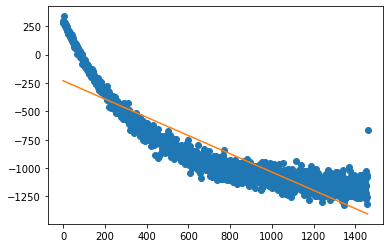

In [31]:
# plt.figure().set_facecolor('white') # no alpha please
# plt.xlabel('epoch')
# plt.ylabel('NLL')
# plt.xlim(left=0.0, right=model.train_epoch_history[-1])
# plt.plot(model.train_nll_history, '-o')
# plt.plot(model.test_epoch_history, model.test_nll_history, '-o')
# plt.legend(['train batch NLL', 'test mean batch NLL'], loc='upper right')
# plt.title('Train and test dataset NLL')
# plt.show(
import matplotlib.pyplot as plt
import numpy

plt.plot(range(len(model.train_nll_history)), model.train_nll_history, 'o')
m, b = np.polyfit(range(len(model.train_nll_history)), model.train_nll_history, 1)
plt.plot(range(len(model.train_nll_history)), m * numpy.array(range(len(model.train_nll_history))) + b)

In [ ]:
model.show_inference([
    'Good-looking bootle. Aroma is pretty astonishig. Sour and sweet palate profile. I like the taste very much. Overall I can recommend it to everyone.',
    'Tastes best from bottle. Not so heap as one could think. Nice hoppy smell. I had not supposed it will be sour though. Beautiful smooth head.',
])

ic| ratings_scores: [tensor([ 0.0150,  0.0127, -0.1828, -0.2618, -0.0268]),
                     tensor([0.7375, 0.4240, 0.3807, 0.5324, 0.5678, 0.6096, 0.6242, 0.5000, 0.2213,
                            0.1847]),
                     tensor([0.0042, 0.1161, 0.1454, 0.5595, 0.1736]),
                     tensor([0.3399, 0.3339, 0.3859, 0.4037, 0.3938, 0.3910, 0.3375, 0.4953, 0.4789,
                            0.2923]),
                     tensor([0.0079, 0.0071, 0.0099, 0.0140, 0.0312, 0.0369, 0.0501, 0.0810, 0.0955,
                            0.1373, 0.1603, 0.2388, 0.2285, 0.2508, 0.2821, 0.2285, 0.1691, 0.0938,
                            0.0193, 0.0095])]
ic| ratings_scores: [tensor([0.1047, 0.2721, 0.4051, 0.9446, 0.7706]),
                     tensor([0.0732, 0.1072, 0.1986, 0.2930, 0.4933, 0.6599, 0.8692, 0.7642, 0.3517,
                            0.1099]),
                     tensor([0.2591, 0.4881, 0.4105, 0.6603, 0.6745]),
                     tensor([0.0363, 0.0459, 0.

Review 0: 
Tokenized review text (stop words removed):
['good', 'looking', 'bootle'] ['aroma', 'pretty', 'astonishig'] ['sour', 'sweet', 'palate', 'profile'] ['like', 'taste'] ['overall', 'recommend']
Review text mapped to word ID-s: [14, 300, 17235] [2, 68, 0] [75, 3, 50, 318] [21, 13] [86, 1052]
Predicted sentences aspects:  appearance aroma palate taste overall
Predicted aspects ratings:  appearance: 0 aroma: 0 palate: 3 taste: 7 overall: 14

Review 1: 
Tokenized review text (stop words removed):
['tastes', 'best', 'bottle'] ['heap', 'think'] ['nice', 'hoppy', 'smell'] ['supposed', 'sour'] ['beautiful', 'smooth', 'head']
Review text mapped to word ID-s: [117, 149, 8] [7873, 175] [11, 49, 143] [1326, 75] [308, 51, 1]
Predicted sentences aspects:  palate overall aroma taste appearance
Predicted aspects ratings:  appearance: 3 aroma: 6 palate: 4 taste: 7 overall: 16



In [ ]:
ic(model.gammas[0][14, 0] + model.gammas[0][300, 0] + model.gammas[0][17235, 0])

ic| model.gammas[0][14, 0] + model.gammas[0][300, 0] + model.gammas[0][17235, 0]: tensor(0.0150)


tensor(0.0150)